# Calculate daily WBGTmean, WBGTmax, WBGThalf

In [3]:
%matplotlib inline

In [18]:
from pathlib import Path
from datetime import date

import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from numba import njit, prange
from scipy import stats
from config import DATA_SRC, WEATHER_SRC

# TODO replace with MetPy
# import wet_bulb_calc
import logging
logging.basicConfig(format='%(asctime)s %(message)s')

In [6]:
MAX_YEAR = 2019

REFERENCE_YEAR_START = 1986
REFERENCE_YEAR_END = 2005

HOURLY_T = WEATHER_SRC / 'era5' / 'hourly_temperature_2m'
HOURLY_DPT = WEATHER_SRC / 'era5' / 'hourly_dewpoint_temperature_2m'
HOURLY_P = WEATHER_SRC / 'era5' / 'hourly_surface_pressure'

In [7]:
INTERMEDIATE_RESULTS_FOLDER = DATA_SRC / 'lancet' / 'wbgt_era5'

In [8]:
WBGT_MEAN_OUT = INTERMEDIATE_RESULTS_FOLDER  / 'daily_wbgtmean'
WBGT_MEAN_OUT.mkdir(exist_ok=True)

WBGT_MAX_OUT = INTERMEDIATE_RESULTS_FOLDER / 'daily_wbgtmax'
WBGT_MAX_OUT.mkdir(exist_ok=True)

WBGT_HALF_OUT = INTERMEDIATE_RESULTS_FOLDER / 'daily_wbgthalf'
WBGT_HALF_OUT.mkdir(exist_ok=True)

RESULTS_FOLDER = Path('./results/labour').absolute()
RESULTS_FOLDER.mkdir(exist_ok=True)

In [9]:
years = list(range(1980, MAX_YEAR+1))

In [11]:
def calculate_relative_humidity(temperature, temperature_dewpoint):
    """
    RH = 100% x (E/Es)

    where, according to an approximation of the Clausius-Clapeyron equation:
    
    E = E0 x exp[(L/Rv) x {(1/T0) - (1/Td)}] and
    
    Es = E0 x exp[(L/Rv) x {(1/T0) - (1/T)}]
    
    where E0 = 0.611 kPa, (L/Rv) = 5423 K (in Kelvin, over a flat surface of water), T0 = 273 K (Kelvin)
    
    
    Parameters
    ----------
    temperature (K): temperature at surface
    temperature_dewpoint (K) : dewpoint temperature at surface

    Returns
    -------
    Relative humidity (%)

    """

    E0 = 0.611
    t_0 = 273.15
    # (L / Rv) = 5423
    L_over_RV = 5423
    E = E0 * np.exp((L_over_RV) * ((1 / t_0) - (1 / temperature_dewpoint)))

    Es = E0 * np.exp((L_over_RV) * ((1 / t_0) - (1 / temperature)))

    RH = 100 * (E / Es)
    return RH

def calculate_wbt_t_dew(t_ref, temperature_dewpoint, surface_pressure):
    """Empirical calculation of wet bulb temperature from temperature, humidity, and pressure

    Parameters
    ----------
        t_ref: Dry bulb near-surface air temperature (K)
        relative_humidity: Relative humidity (%)
        surface_pressure: Surface air pressure (Pa)

    Returns
    -------
        Wet Bulb Temperature
    """

    # Empirical formula for e_sat
    a = (-2991.2729 / t_ref ** 2)
    b = -6017.0128 / t_ref
    c = -0.028354721 * t_ref
    d = 1.7838301E-5 * t_ref ** 2
    e = -8.4150417E-10 * t_ref ** 3
    f = 4.4412543E-13 * t_ref ** 4
    g = 2.858487 * np.log(t_ref)
    e_sat = np.exp(18.87643854 + a + b + c + d + e + f + g) / 100
    surface_pressure = surface_pressure / 100
    w_sat = 621.97 * e_sat / (surface_pressure - e_sat)
    
    relative_humidity = calculate_relative_humidity(t_ref, temperature_dewpoint)
    
    humidity_frac = relative_humidity / 100
    w = humidity_frac * w_sat
    t_l = 1 / (1 / (t_ref - 55) - np.log(humidity_frac) / 2840) + 55
    t_e = t_ref * (1000 / surface_pressure) ** (0.2854 * (1 - 0.28E-3 * w)) * np.exp(
        (3.376 / t_l - 0.00254) * w * (1 + 0.81E-3 * w))

    wbt = 45.114 - 51.489 * (t_e / 273.15) ** (-3.504)  # in ˚C
    # Standardize on kelvin for sanity
    return wbt + 273.15



def calculate_wbt(t_ref, relative_humidity, surface_pressure):
    """Empirical calculation of wet bulb temperature from temperature, humidity, and pressure

    Parameters
    ----------
        t_ref: Dry bulb near-surface air temperature (K)
        relative_humidity: Relative humidity (%)
        surface_pressure: Surface air pressure (Pa)

    Returns
    -------
        Wet Bulb Temperature
    """

    # Empirical formula for e_sat
    a = (-2991.2729 / t_ref ** 2)
    b = -6017.0128 / t_ref
    c = -0.028354721 * t_ref
    d = 1.7838301E-5 * t_ref ** 2
    e = -8.4150417E-10 * t_ref ** 3
    f = 4.4412543E-13 * t_ref ** 4
    g = 2.858487 * np.log(t_ref)
    e_sat = np.exp(18.87643854 + a + b + c + d + e + f + g) / 100
    surface_pressure = surface_pressure / 100
    w_sat = 621.97 * e_sat / (surface_pressure - e_sat)
    humidity_frac = relative_humidity / 100
    w = humidity_frac * w_sat
    t_l = 1 / (1 / (t_ref - 55) - np.log(humidity_frac) / 2840) + 55
    t_e = t_ref * (1000 / surface_pressure) ** (0.2854 * (1 - 0.28E-3 * w)) * np.exp(
        (3.376 / t_l - 0.00254) * w * (1 + 0.81E-3 * w))

    wbt = 45.114 - 51.489 * (t_e / 273.15) ** (-3.504)  # in ˚C
    # Standardize on kelvin for sanity
    return wbt + 273.15


def calculate_wbgt(t_ref, relative_humidity, surface_pressure):
    """
    Returns
    -------
        WBGT (K)
    """
    wbt = calculate_wbt(t_ref, relative_humidity, surface_pressure)
    # Formula supplied in ˚C but want everything in Kelvin
    wbgt = 0.7 * (wbt - 273.15) + 0.3 * (t_ref - 273.15)
    return wbgt + 273.15


# def calculate_wbgt_from_wbt(t_ref, wbt):
#     # Formula supplied in ˚C but want everything in Kelvin
#     wbgt = 0.7 * (wbt - 273.15) + 0.3 * (t_ref - 273.15)
#     return wbgt + 273.15


def calculate_wbgt_t_dew(t_ref, temperature_dewpoint, surface_pressure):
    """
    Calculate WBGT from temperature, dewpoint temperature, and pressure

    Parameters
    ----------
    t_ref: Dry bulb near-surface air temperature (K)
    temperature_dewpoint: Dewpoint temperature
    surface_pressure: pressure

    Returns
    -------
    WBGT (K)

    """
    wbt = calculate_wbt_t_dew(t_ref, temperature_dewpoint, surface_pressure)
    wbgt = 0.7 * (wbt - 273.15) + 0.3 * (t_ref - 273.15)
    return wbgt + 273.15
    
    

def process_year(year):
    logging.warning('Open input data')
    # Try to get about 1million elements per chunk
    chunksizes = {'time': 4, 'latitude':360, 'longitude': 720}
    t2m = xr.open_dataarray(HOURLY_T / f'{year}_temperature.grib', engine='cfgrib', 
                        chunks=chunksizes
                           )
    dpt = xr.open_dataarray(HOURLY_DPT / f'{year}_dpt.grib', engine='cfgrib', 
                        chunks=chunksizes
                           )
    pr = xr.open_dataarray(HOURLY_P / f'{year}_surface_pressure.grib', engine='cfgrib', 
                        chunks=chunksizes
                          )
    
    logging.warning('Running calculation')
    wbgt = calculate_wbgt_t_dew(t2m, dpt, pr)
    wbgt.name = 'wbgt'
    wbgt = wbgt.astype(np.float32).to_dataset()
    wbgt = wbgt.compute()
    
    logging.warning('Resampling')
    resamp = wbgt.resample(time='1D')
    
    # reuse the same var to avoid holding copies
    logging.warning('Saving mean')
    agg = resamp.mean()
    agg.to_netcdf(WBGT_MEAN_OUT / f'wbgt_mean_{year}.nc',
                       encoding={'wbgt': {'dtype': 'int16', 'scale_factor': 0.01, '_FillValue': -9999}})
    
    logging.warning('Saving max')
    agg = resamp.max()
    agg.to_netcdf(WBGT_MAX_OUT / f'wbgt_max_{year}.nc',
                       encoding={'wbgt': {'dtype': 'int16', 'scale_factor': 0.01, '_FillValue': -9999}})
    return year

## Generate Relative Humidity

> We just calculate this in the process of calculating WBT

## Generate WBT

> Similar to Relative Humidty, can skip if we directly calculate WBGT without saving intermediate data

## Generate WBGT max, mean

 > Enable serial or parallel version depending on available capacity

In [1]:
# Parallel(n_jobs=3, verbose=10)(delayed(process_year_numbaless)(year) for year in range(1986, 2000)) 

In [2]:
for year in range(1986, MAX_YEAR+1):
    print(year)
    process_year(year)

## Calculate WBGThalf

WBGThalf = the half way point between WBGTmax and WBGTmean.

In [22]:
def wbgt_half_for_year(year):
    wbgt_mean = xr.open_dataarray(INTERMEDIATE_RESULTS_FOLDER/ 'daily_wbgtmean'/ f'wbgt_mean_{year}.nc')
    wbgt_max = xr.open_dataarray(INTERMEDIATE_RESULTS_FOLDER/ 'daily_wbgtmax'/ f'wbgt_max_{year}.nc')
    wbgt_half = wbgt_mean + (wbgt_max - wbgt_mean) / 2
    wbgt_half = wbgt_half.astype(np.float32)
    wbgt_half.to_netcdf(WBGT_HALF_OUT / f'wbgt_half_{year}.nc',
                       encoding={'wbgt': {'dtype': 'int16', 'scale_factor': 0.01, '_FillValue': -9999}})

In [24]:
out = Parallel(n_jobs=10)(delayed(wbgt_half_for_year)(year) for year in tqdm(years))

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

## Plots for appendix

In [9]:
wbgt_mean = xr.open_mfdataset(str(WEATHER_SRC / 'ecmwf' / 'daily_wbgtmean'/ 'wbgt_mean_*.nc'))

In [10]:
wbgt_mean = wbgt_mean.resample(time='1Y').mean()

In [11]:
wbgt_mean_ts = wbgt_mean.resample(time='1Y').mean().mean(dim=['latitude', 'longitude']).compute()

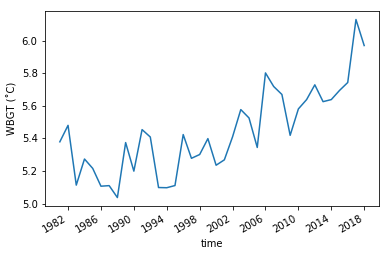

In [6]:
(wbgt_mean_ts.wbgt - 273.15).plot()
plt.ylabel('WBGT (˚C)')
plt.savefig(RESULTS_FOLDER / 'wbgt_yearly_mean.png', dpi=300)

In [12]:
wbgt_baseline = wbgt_mean.wbgt.sel(time=wbgt_mean.time.loc[f'{REFERENCE_YEAR_START}-01-01': f'{REFERENCE_YEAR_END}-12-31']).groupby('time.dayofyear').mean(dim='time')

In [13]:
def do_day_sub(year_data):
    year_data['time_bak'] = year_data['time']
    year_data['time'] = year_data['time.dayofyear']
    year_data = year_data.rename({'time': 'dayofyear'})
    # rename to align
    delta = year_data - wbgt_baseline
    delta['dayofyear'] = delta['time_bak']
    delta = delta.rename({'dayofyear': 'time'})
    delta = delta.drop('time_bak')
    return delta


wbgt_delta = wbgt_mean.wbgt.groupby('time.year').apply(do_day_sub)

In [14]:
cos_lat = np.cos(np.radians(wbgt_delta.latitude))

In [15]:
wbgt_delta_ts = (wbgt_delta.groupby('time.year').mean(dim='time') * cos_lat).mean(dim=['latitude', 'longitude']).compute()

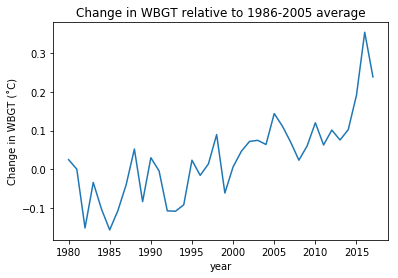

In [23]:
wbgt_delta_ts.plot()
plt.ylabel('Change in WBGT (˚C)')
plt.title('Change in WBGT relative to 1986-2005 average')
plt.savefig(RESULTS_FOLDER / 'wbgt_delta_mean.png', dpi=300)

In [16]:
import population_tools

In [17]:
wbgt_delta_popweight_ts = population_tools.project_to_population(wbgt_delta.groupby('time.year').mean(dim='time'), norm=True).compute()

In [18]:
df = wbgt_delta_ts.to_dataframe('wbgt_delta_mean').join(wbgt_delta_popweight_ts.to_dataframe('wbgt_delta_exposure'))
df.to_excel(RESULTS_FOLDER / 'wbgt_delta_yearly_mean.xlsx')

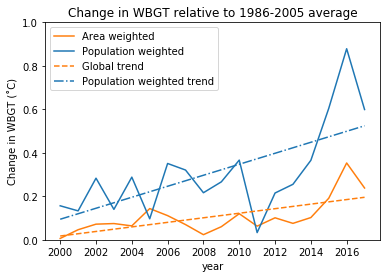

In [22]:
wbgt_delta_ts = wbgt_delta_ts.sel(year=slice(2000,None))
wbgt_delta_ts.plot(color='C1', label='Area weighted')
wbgt_delta_popweight_ts.plot(color='C0', label='Population weighted')


anom_reg = stats.linregress(wbgt_delta_ts.year.values, wbgt_delta_ts.values)
anom_reg = (anom_reg.slope * wbgt_delta_ts.year) + anom_reg.intercept

exposures_reg = stats.linregress(wbgt_delta_popweight_ts.year.values, wbgt_delta_popweight_ts.values)
exposures_reg = (exposures_reg.slope * wbgt_delta_popweight_ts.year) + exposures_reg.intercept

anom_reg.plot.line('--', color='C1', label='Global trend')
exposures_reg.plot.line('-.', color='C0', label='Population weighted trend')

plt.xticks(list(range(2000, MAX_YEAR + 1, 2)))

plt.ylim(0,1)
plt.ylabel('Change in WBGT (˚C)')
plt.title('Change in WBGT relative to 1986-2005 average')
plt.legend()
plt.savefig(RESULTS_FOLDER / 'wbgt_delta_yearly_mean.png', dpi=300)

# TODO more accurate method of calculating WBGT


In [ ]:
def fWBGTi(T_air, T_dew):
    # First step Psychrometric Wet bulb temperature calculation
    if T_dew > T_air:
        fWBGTi = T_air
        return fWBGTi

    # Iteration to get Tw from Td       
    Tw = T_dew
    Diff = 10000
    Ed = 0.6106 * np.exp(17.27 * T_dew / (237.3 + T_dew))
    while np.abs(Diff) + np.abs(Diffold) == np.abs(Diff + Diffold):
        Diffold = Diff
        Ew = 0.6106 * np.exp(17.27 * Tw / (237.3 + Tw))
        Diff = 1556 * Ed + 101 * Ta - 1556 * Ew + 1.484 * Ew * Tw - 1.484 * Ed * Tw - 101 * Tw
        Tw = Tw + 0.2
        if Tw > T_air:
            break
        
        if Tw > T_dew + 0.2:
            Tw = Tw - 0.2
        else:
            Tw = T_dew
    # Use Bernard formula to calculate natural wet bulb temperature from psychrometric wet bulb temperature for 1m/s wind speed
    fWBGTi = 0.67 * Tw + 0.33 * T_air
    return fWBGTi